# EXERCISE 1 - ML - Grundverfahren SS 23

Ge Li ge.li@kit.edu. This homework has totally 13 points.

## Submission Instructions
Submission deadline: May 17, 2023, 15:00. Please follow the instruction from homework ZERO! 


## 1.) Linear Regression

### 1.1) Matrix Vector Calculus (1 Point)
Given the following element-wise expression of a matrix-vector product,
rewrite it in matrix form:

\begin{align*}
        g = \alpha \sum_i \sum_j \sum_k z_k x_{ij} q_i y_{jk}
\end{align*}



##Todo

### 1.2) Derive Ridge Regression Weights (4 Points)
Derive the optimal solution of weights in Ridge Regression using matrix form, i
.e. $\boldsymbol{w}= ?$

Hint: You will need derivatives for vectors/matrices. Start
from the matrix objective for ridge regression as stated here

\begin{align*}
L &= (\boldsymbol{y}-\boldsymbol{\Phi} \boldsymbol{w})^T(\boldsymbol{y}-\boldsymbol{\Phi} \boldsymbol{w}) + \lambda \boldsymbol{w}^T \boldsymbol{I} \boldsymbol{w}. \\
\end{align*}


## Todo

### Ridge Regression - Code
Let's first get the data


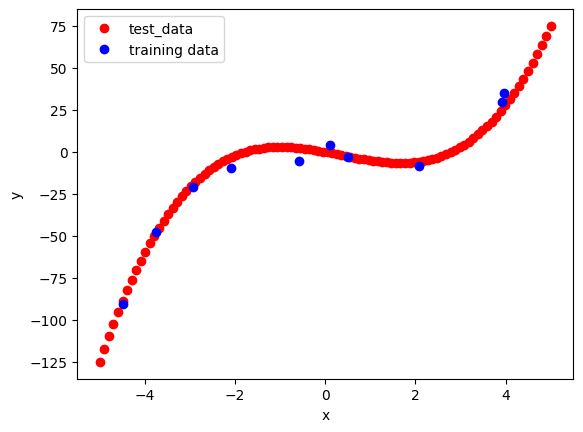

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Load data

training_data = np.load('training_data.npy')
test_data = np.load('test_data.npy')

test_data_x = test_data[:, 0]
test_data_y = test_data[:, 1]

training_data_x = training_data[:, 0]
training_data_y = training_data[:, 1]

# Visualize data
plt.plot(test_data_x, test_data_y, 'or')
plt.plot(training_data_x, training_data_y, 'ob')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(["test_data", "training data"])

As in the lecture notebook, we will use polynomial-features here again.
The following functions will be used for:
- calculating polynomial features
- computing the mean and std of the features (training data) as normalizer
- normalize other data (test) features using the normalizer (mean and std)
- evaluating the model
- calculating the Mean Squarred Error for assigning a performance to each
model. <br><br>

Note we will use the mean and the standard deviation to normalize our features
according to:
\begin{align*}
    \boldsymbol{\tilde{\Phi}} = \frac{\boldsymbol{\Phi}(\boldsymbol{x}) - \boldsymbol{\mu}_{\Phi}}{\boldsymbol{\sigma}_{\Phi}}, 
\end{align*}
where $\boldsymbol{\tilde{\Phi}}$ are the (approximately) normalized features to any input
$\boldsymbol{x}$ (not necessarily the training data), $\boldsymbol{\mu}_{\Phi}$ is the mean of the features applied to the training data and $\boldsymbol{\sigma}_{\Phi}$ is the standard deviation of the features applied to the training data for each dimension.<br>

Normalization is a standard technique used in Regression to avoid numerical problems and to obtain better fits for the weight vectors $\boldsymbol{w}$. Especially when the features transform the inputs to a very high value range, normalization is very useful. In this homework we will use features of degree 10. Since the input range of the data is roughly from -4 to 4 this will lead to very high values for higher order degrees. By normalizing each dimension of the feature matrix, we will map each dimension of the feature matrix applied to the training data to a zero mean unit variance distribution.

In [2]:
def get_polynomial_features(data: np.ndarray,
                            degree: int) ->np.ndarray:
    """
    Function to create Feature Matrix. Extends the feature matrix according to
    the matrix form discussed in the lectures.

    :param data: data points you want to evaluate the polynomials,
                 shape: [n_samples] (we have 1-dim data)
    :param degree: degree of your polynomial, shape: scalar
    :return polynomial_features: shape [n_samples x (degree+1)]
    """
    polynomial_features = np.ones(data.shape)
    for i in range(degree):
        polynomial_features = np.column_stack((polynomial_features, data ** (i + 1)))
    return polynomial_features


def get_mean_std_features(polynomial_features: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Function for calculating the mean and standard deviation of the features
    :param polynomial_features: shape: [n_samples x (degree+1)]
    :return mean_feat: mean vector of the features,
            shape:[1 x (degrees+1)]
    :return std_feat: standard deviation (for each dimension in feature matrix),
                      shape: [1 x (degrees+1)] 
    """
    mean_feat = np.mean(polynomial_features, axis=0, keepdims=True)
    mean_feat[:, 0] = 0.0 # we don't want to normalize the bias
    std_feat = np.std(polynomial_features, axis=0, keepdims=True)
    std_feat[:, 0] = 1.0 # we don't want to normalize the bias
    return mean_feat, std_feat


def normalize_features(polynomial_features: np.ndarray,
                       mean_train_features: np.ndarray,
                       std_train_features: np.ndarray) ->np.ndarray:
    """
    Normalize features
    :param polynomial_features:  features to be normalized,
                 shape: [n_samples x (degree+1)]
    :param mean_train_features: mean of the feature matrix of the training set,
                 shape: [1 x (degrees+1)]
    :param std_train_features: std of the feature matrix of the training set,
                 shape: [1 x (degrees+1)]
    :return norm_feat: normalized features, shape: [n_samples x (degree+1)]
    """

    # note: features: (n_samples x n_dims),
    #       mean_train_features: (1 x n_dims),
    #       std_train_features:  (1 x n_dims)
    #       due to these dimensionalities we can do element-wise operations.
    #       By this we normalize each dimension independently
    norm_feat = (polynomial_features - mean_train_features) / std_train_features
    return norm_feat


def eval(Phi:np.ndarray, w:np.ndarray)->np.ndarray:
    """
    Evaluate the models

    :param Phi: Feature matrix, shape: [n_samples x (degree+1)]
    :param w: weight vector, shape: [degree + 1]
    :return : predictions, shape [n_samples] (we have 1-dim data)
    Evaluates your model
    """
    return np.dot(Phi, w)


def mse(y_target:np.ndarray, y_pred:np.ndarray)->np.ndarray:
    """
    :param y_target: the target outputs,
            shape: [n_samples] (here 1-dim data)
    :param y_pred: the predicted outputs,
            shape: [n_samples](we have 1-dim data)
    :return : The Mean Squared Error, shape: scalar
    """
    diff = y_target - y_pred
    return np.sum(diff ** 2, axis=0) / y_pred.shape[0]


### 1.3) Implement Ridge Regression Weights (2 Point)
The following function will calculate the weights for ridge regression. Fill in the missing code according to the formula for calculating the weight updates for ridge regression. <br>
Recall that the formula is given by 
\begin{align*}
    \boldsymbol{w} &= (\boldsymbol{\Phi} ^T \boldsymbol{\Phi} + \lambda \boldsymbol{I} )^{-1} \boldsymbol{\Phi}^T \boldsymbol{y},
\end{align*}
where $\boldsymbol{\Phi}$ is the feature matrix (the matrix storing the data points applied to the polynomial features).
Hint: use np.linalg.solve for solving for the linear equation.
If you got confused because of the normalization described before, don't worry, you do not need to consider it here :)

In [ ]:
def calc_weights_ridge(Phi:np.ndarray,
                       y:np.ndarray,
                       ridge_factor:float)->np.ndarray:
    """
    :param Phi: Feature Matrix, shape: [n_samples x (degree+1)]
    :param y: Output Values, [n_samples] (we have 1-dim data)
    :param ridge_factor: lambda value, shape: scalar
    :return : The weight vector, calculated according to the equation shown before,
            shape: [degrees +1]
    """
    ##################
    ##TODO
    #################

For demonstrating ridge regression we will pick the polynomial degree of 10. In the lecture notebook we have seen that this model is highly overfitting to the data.
We will investigate the role of the ridge factor $\lambda$. For that purpose we first need to calculate the weights for different $\lambda$ values. <br>
We will pick $\lambda = [1e-{6}, 1e-{3}, 1, 3, 5,10,20,30,40,50, 1e2, 1e3, 1e5] $ to see the differences of the values. <br><br>

Practical note. We use here very high values for $\lambda$ for demonstration
purposes here. In practice we would not choose a model where we know from
beginning that it is highly overfitting. When choosing an appropriate model, the value needed for $\lambda$ automatically will be small (often in the range of $1e^{-6}$ or smaller).

In [ ]:
# Let's do it on polynomial degree 10 and see the results

# first we get the mean and the standard deviation of the training feature matrix, which we will use for normalization
train_features = get_polynomial_features(training_data_x, 10)
test_features = get_polynomial_features(test_data_x, 10)
mean_train_feat, std_train_feat = get_mean_std_features(train_features)
norm_train_features = normalize_features(train_features, mean_train_feat, std_train_feat)
norm_test_features = normalize_features(test_features, mean_train_feat, std_train_feat)


# now we can calculate the normalized features for degree 10
ridge_factors = [1e-6, 1e-3, 1, 3, 5, 10,20,30,40, 50, 1e2, 1e3, 1e5]
weights_ridge = []

for lambda_val in ridge_factors:
    weights_ridge.append(calc_weights_ridge(norm_train_features, training_data_y, lambda_val))

# We further have to perform the predictions based on the models we have calculated
y_training_ridge = []
y_test_ridge = []

for w in weights_ridge:
    y_training_ridge.append(eval(norm_train_features, w))
    y_test_ridge.append(eval(norm_test_features, w))

We are interested in the mean squarred error on the test and the training data. For that purpose we calculate them here and plot the errors for different $\lambda$ values in log space. 

In [ ]:
training_error_ridge = []
test_error_ridge = []

for i in range(len(y_training_ridge)):
    training_error_ridge.append(mse(training_data_y, y_training_ridge[i]))
    test_error_ridge.append(mse(test_data_y, y_test_ridge[i]))

error_fig_ridge = plt.figure()
plt.figure(error_fig_ridge.number)
plt.title("Error Plot Ridge Regression")
plt.xlabel("$\lambda$")
plt.ylabel("MSE")
x_axis = ["$1e-{6}$", "$1e-{3}$", "$1$", "$3$", "$5$","$10$","$20$","$30$","$40$","$50$",
          "$1e2$", "$1e3$", "$1e5$"]
plt.yscale('log')
plt.plot(x_axis, training_error_ridge, 'b')
plt.plot(x_axis, test_error_ridge, 'r')
# let's find the index with the minimum training error
min_error_idx = np.argmin(test_error_ridge)
plt.plot(x_axis[min_error_idx], test_error_ridge[min_error_idx], 'xg')
plt.legend(['Training Error', 'Test Error', 'Min Test Error'])


In [ ]:
# Let us visualize the newly fitted model with the optimal lambda value here
x = np.linspace(-5, 5, 100)
new_features = get_polynomial_features(x, 10)
new_norm_feat = normalize_features(new_features, mean_train_feat, std_train_feat)
y_pred = eval(new_norm_feat, weights_ridge[min_error_idx])

plt.plot()
plt.plot(test_data_x, test_data_y, 'or')
plt.plot(training_data_x, training_data_y, 'ob')
plt.plot(x, y_pred)
plt.legend(["test_data", "training_data", "inference"])


### 1.4) Error Plot (1 Point)
In the lecture we have seen and analyzed the plot of polynomial degrees 
against the error (slide  39).
Similarly, now please analyze the relationship between the error and the 
different values of $\lambda$, as well as the reason behind it.

Hint: Do not forget that we are in log space. Small changes in the y-axis mean high differences in the error values. <br><br>

##TODO

## 2) Kernel Ridge Regression

In this task, we are going to get familiar with the kernel method and perform Kernel Ridge Regression using Gaussian kernels.

Work flow:
- Load and plot data
- Implement a function to get the Gaussian kernel vector
- Implement a function to get the Gaussian kernel matrix
- Implement a function to apply Kernel Ridge Regression
- Select best model and see some result plots


### Load and plot data
First, let us load and plot our data. Note that in this example the test data is not corrupted by noise.


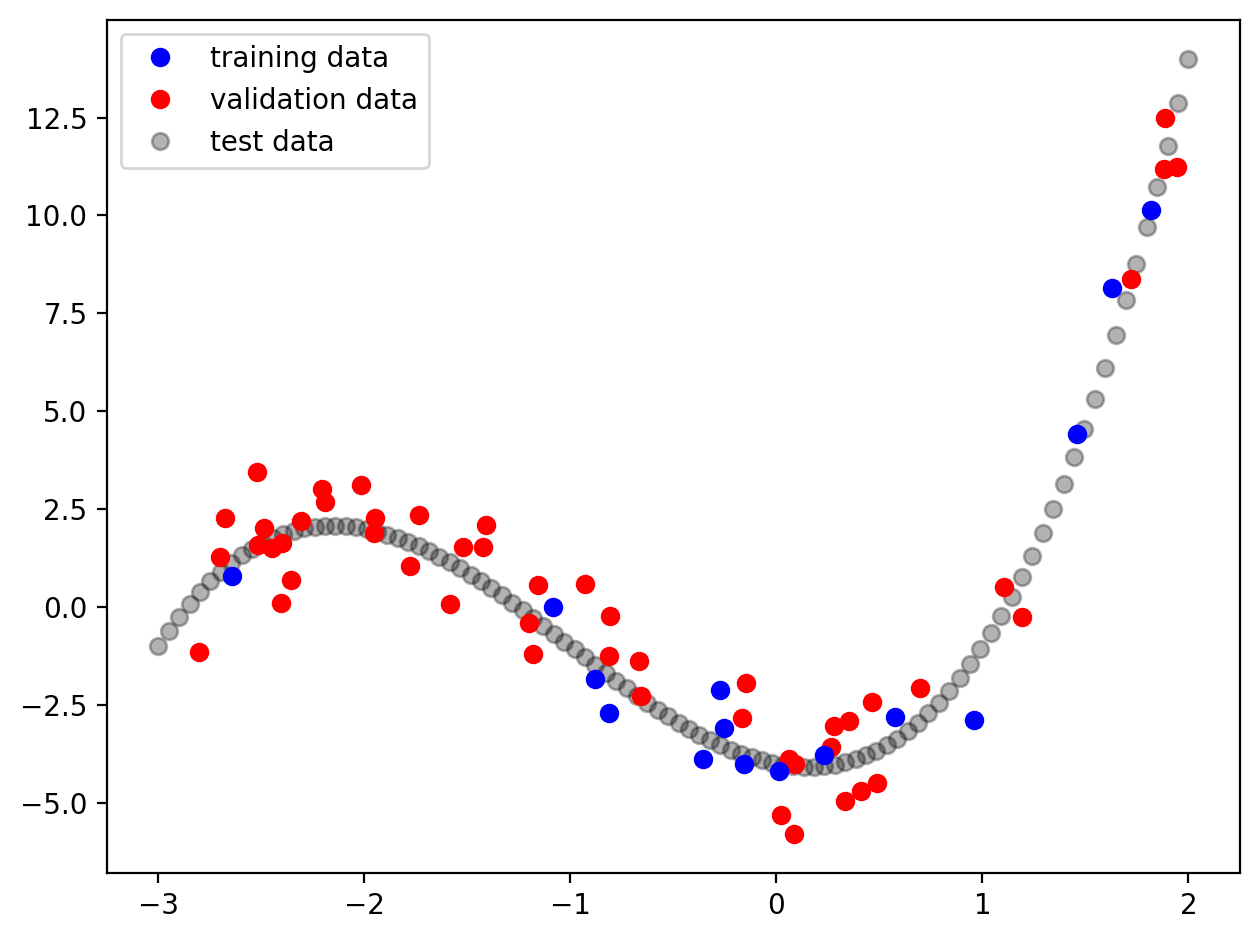

In [3]:


# Set random seed to obtain reproducible results
np.random.seed(0)

# Load training, validation and test datasets
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

x_valid = np.load('x_valid.npy')
y_valid = np.load('y_valid.npy')

x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

# Plot the data
plt.figure(dpi=200, tight_layout=True)
plt.plot(x_train, y_train, 'ob', label='training data', zorder=20)
plt.plot(x_valid, y_valid, 'or', label='validation data',zorder=10)
plt.plot(x_test, y_test, 'ok', label='test data', alpha=0.3, zorder=0)
plt.legend()
plt.show()


### 0. Training, Validation and Testing datasets (1pt)
In this homework, we are going to use a new type of dataset "validation" to help select our best hyperparameter and avoid overfitting. Please read the explanation below and understand the roles of training, validation and testing datasets respectively (1pt).

Training, validation, and test datasets are three distinct subsets of a larger dataset that are used in the process of building and evaluating machine learning models.

The training dataset is the subset of the data that is used to train a machine learning model. In other words, it's the data that the model learns from. Typically, the training dataset makes up the majority of the available data.

The validation dataset is used to evaluate the performance of a model during the training process. It's a subset of the data that is held back from the training process and used to tune the model's hyperparameters, such as learning rate, number of hidden layers, etc. The goal of the validation dataset is to help prevent overfitting, which is when the model memorizes the training data and performs poorly on new, unseen data.

The test dataset is a completely separate subset of the data that is used to evaluate the final performance of a trained model. It represents real-world data that the model has never seen before and is used to estimate the model's accuracy on new, unseen data. The test dataset should only be used after the model has been trained and validated to prevent any bias in the evaluation.

It's important to note that the three datasets should be independent and identically distributed (IID) to ensure that the model is able to generalize well to new data. In addition, the sizes of the datasets may vary depending on the size and complexity of the original dataset and the specific requirements of the machine learning problem at hand.

(Note: In our homework, however, we are going to use a large and denoised test dataset which is for plotting convienence.)

### Gaussian Kernels:
Since Gaussian kernels are the most commonly used kernels, we will concentrate on Gaussian kernels in this notebook. Remember the definition of a Gaussian kernel (slide 55):\
\begin{align*}
    k(\boldsymbol{x}, \boldsymbol{x^*}) = \exp\left(-\frac{||\boldsymbol{x}-\boldsymbol{x^*}||^2}{2\sigma^2}\right),
\end{align*}
where $\boldsymbol{x}, \boldsymbol{x^*}$ are two $d$-dimensional data points. $ \sigma $ is the bandwidth hyperparameter. Recall that any kernel $k(\boldsymbol{x}, \boldsymbol{x^*})$ returns a scalar which represents some kind of discrepancy measure between two data points.



### 1. Kernel Vector (3pts)
Now we are going to implement a function to compute the kernel vector $\boldsymbol k(\boldsymbol x^*)$ (slide 59). Recall the definition: given $N$ training points $\boldsymbol{x_i}, i=1,...,N$, and one additional query point $\boldsymbol{x^*}$, $\boldsymbol{k(x^*)}$ is defined as the $N$-dimensional vector whose $i$-th element is given by the kernel, evaluated at training point $\boldsymbol{x_i}$ and the query point, i.e. $k(\boldsymbol{x_i, x^*})$.

Please finish the function below!

Hints:
- As we typically have $M > 1$ query points in practice, we would like to compute the corresponding $M$ kernel vectors in one function call, cf. the comments.
- The computations we have to perform are the same as in `gaussian_kernel()`. However, we are now operating on more than one input vectors at once.
- Avoid using loops! To this end, you may need to add additional dimensions to the input data and use broadcasting. Also, note that numpy operations such as `np.linalg.norm()` can operate on vector inputs and take an `axis`-argument!
- Make sure your code works also for data with dimension larger than 1. You are going to need this later.

In [ ]:
def get_kernel_vec(X_t: np.ndarray,
                   X_q: np.ndarray,
                   sigma: float) -> np.ndarray:
    """
    :param X_t: N training inputs (shape: [N, d])
    :param X_q: M query inputs (shape: [M, d])
    :param sigma: bandwidth of the kernel (shape: scalar)
    :return: M kernel vectors arranged as the columns of a matrix with shape [N, M]
    """
    ############## Your code starts here ##############

    ############### Your code ends here ###############

    # assert the output shape being [N, M]
    assert list(kernel_vectors.shape) == [X_t.shape[0], X_q.shape[0]]
    return kernel_vectors

### Radial Basis Function (RBF) features
Now we use `get_kernel_vec()` to compute the kernel vectors w.r.t. our training inputs, using the test inputs as the query points. This allows us to plot the RBF features: we observe that at each training data point a Gaussian bump (the Gaussian kernel) is centered and that the bandwith parameter specifies the width of each bump.

In [ ]:
# Run this block to test your code

# Compute the kernel vectors w.r.t. the training inputs, using the test inputs as query points
kernel_vectors = get_kernel_vec(x_train, x_test, 0.5)
kernel_vectors2 = get_kernel_vec(x_train, x_test, 0.2)

# Prepare plot
plt.figure(dpi=200, tight_layout=True)

# Plot the data
plt.subplot(3,1,1)
plt.plot(x_train, y_train, 'ro')
plt.plot(x_test, y_test, 'k')
plt.legend(['training data', 'ground_truth'])

# Plot the kernel vectors
plt.subplot(3,1,2)
for kernel in kernel_vectors:
    plt.plot(x_test, kernel, 'b')

plt.subplot(3,1,3)
for kernel in kernel_vectors2:
    plt.plot(x_test, kernel, 'b')
plt.show()

### Kernel Ridge Regression with Gaussian Kernels

Let's go ahead and do regression using Gaussian kernels. Remember the regression equation (slide 67):

\begin{align*}
    f(\boldsymbol{x^*}) = \boldsymbol{k}(\boldsymbol{x^*})^T(\boldsymbol{K} + \lambda \boldsymbol{I})^{-1}\boldsymbol{y},
\end{align*}
where $ \boldsymbol{k}(\boldsymbol{x^*}) $ is the kernel vector, $ \boldsymbol{K}$ is the kernel matrix and $ \boldsymbol{y} $ are the target values from the training data.

### 2. Kernel Matrix (1pt)
First, we have to compute the kernel matrix $\boldsymbol K$ (slide 59). Recall the definition: $[\boldsymbol K]_{ij} = k(\boldsymbol x_i, \boldsymbol x_j)$ with our training inputs $\boldsymbol{x_i}, i=1,...,N$.

Implement the function below (hint: re-use the `get_kernel_vec()` function)!

In [ ]:
def get_kernel_mat(X: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X: N training inputs (shape [N, d])
    :sigma: bandwidth of the kernel (scalar)
    :return: the kernel matrix (shape [N, N])
    """
    ############## Your code starts here ##############

    ############### Your code ends here ###############
    # assert the output shape being [N, N]
    assert list(kernel_mat.shape) == [X.shape[0], X.shape[0]]
    return kernel_mat

### 3. Kernel Regression Prediction (2pts)
Now that we have finished the implementation of the kernel vector $\boldsymbol{k(x^*)}$ and the kernel matrix $\boldsymbol{K}$, we can compute the prediction $f(\boldsymbol{x^*})$ in the function in below. Here we choose a fixed ridge factor $ \lambda = 10^{-3}$.

Hint: make sure you use numerically stable operations!


In [ ]:
def predict(X_t: np.ndarray, y_t: np.ndarray,
            X_q: np.ndarray, sigma: float) -> np.ndarray:
    """
    :param X_t: N training inputs (shape [N, d])
    :param y_t: N training targets (shape [N, 1])
    :param X_q: M query inputs (shape [M, d])
    :param sigma: bandwidth of the kernel (scalar)
    :return: predicted values at X_q (shape [M, 1])
    """
    k = get_kernel_vec(X_t, X_q, sigma) # shape [N, M]
    K = get_kernel_mat(X_t, sigma) # shape [N, N]
    ridge_factor = 1e-3
    ############## Your code starts here ##############

    ############### Your code ends here ###############
    return prediction

### Mean Squared Error
Once again, we will use the mean squared error to measure the training and test error:

In [ ]:
def mse(y_target: np.ndarray, y_pred: np.ndarray) -> float:
    """
    :param y_target: true y values
    :param y_pred: predicted y values
    :return: MSE
    """
    return np.sum((y_target-y_pred)**2)/y_pred.shape[0]

### Model selection
The Gaussian kernel method introduces a hyperparameter (the bandwidth $\sigma$). We have to determine its value via model selection. Here, we use the hold-out method, i.e., we try different $\sigma$ values and select the model which performs best on the validation dataset.

In [ ]:
sigmas = [0.01, .1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10]

# compute train and validation errors for the different sigma values
train_errors = []
validate_errors = []
for sigma in sigmas:
    predict_train = predict(X_t=x_train, y_t=y_train,
                              X_q=x_train, sigma=sigma)
    predict_valid = predict(X_t=x_train, y_t=y_train,
                             X_q=x_valid, sigma=sigma)
    train_errors.append(mse(y_train, predict_train))
    validate_errors.append(mse(y_valid, predict_valid))

# determine best model
min_valid_error_index = validate_errors.index(min(validate_errors))
print(f'minimum validation error for sigma = {sigmas[min_valid_error_index]:.2f}')

# plot the errors
x_axis = [str(x) for x in sigmas]
error_plot = plt.figure(dpi=200, tight_layout=True)
plt.plot(x_axis, train_errors, 'b')
plt.plot(x_axis, validate_errors, 'r')
plt.plot(x_axis[min_valid_error_index], validate_errors[min_valid_error_index], 'gx')
plt.xlabel( "$\sigma$")
plt.ylabel( "MSE" )
plt.legend(['train error', 'validation error','min error'])

We again observe the typical behavior: we have clear overfitting for small $ \sigma $ values (high model complexity). For high $ \sigma $ values (low model complexity) we observe underfitting. The best performing model is marked with a green 'x', as the minimum validation error is achieved for $ \sigma = 3 $.

Let's look at predictions for different $ \sigma $ values.

In [ ]:
# plot predictions for various bandwith parameters
for sigma in [5.0,  3.0, 1.0 , 0.1]:
    # compute predictions on train, test, and validation sets
    y_pred_train = predict(X_t=x_train, y_t=y_train, X_q=x_train, sigma=sigma)
    y_pred_valid = predict(X_t=x_train, y_t=y_train, X_q=x_valid, sigma=sigma)
    y_pred_test = predict(X_t=x_train, y_t=y_train, X_q=x_test, sigma=sigma)

    # print MSEs
    print(f'sigma = {sigma:.2f}')
    print(f'MSE train: {mse(y_train, y_pred_train):.2f}')
    print(f'MSE valid: {mse(y_valid, y_pred_valid):.2f}')
    print(f'MSE test : {mse(y_test, y_pred_test):.2f}')

    # plot predictions
    sigma_fig = plt.figure(dpi=75, tight_layout=True)
    plt.plot(x_train, y_train, 'ro')
    plt.plot(x_test, y_test, 'k')
    plt.plot(x_test, y_pred_test, 'y')
    plt.legend(['Training data', 'Ground-truth', '$\sigma$ =' + str(sigma)])
    plt.show()

We again observe that the model overfits for $ \sigma < 3.0 $ and underfits for $\sigma > 3.0$, with $\sigma = 3.0$ achieving the minimum validation error.

Note that the model prediction reverts back to $0$ far away from training data (where "far away" has to be understood relative to the bandwidth $\sigma$). E.g., for $ \sigma = 0.1 $, the model prediction reverts back to $0$ in the input region [-2.5, -1.5] as all training points are "far away" w.r.t. the small bandwith value.